In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [22]:
columns = ['Start', 'End', 'Price_start', 'Price_end', 'Move', 'Move_Percent', 'step', 'delta']

def market_move(data, step=15, delta=15):
    df = pd.DataFrame(columns=columns)
    #Avoid outliers by dropping pennies
    data = data[data['Close'] > 1]
    len = data.shape[0]
    idx = min = max = 0
    prev_trend = trend = None
    start = end = prev_start = prev_end = 0
    local_end = 0
    while True:
        # Initialize trend and Start
        start = idx
        prev_trend = trend
        # Condition to go through all the data
        if idx+step <= len:
            local_end = step
        elif idx < len:
            local_end = len-idx
        else:
            break
        arr = data[idx:idx+local_end]['Close'].to_numpy()

        # Find Min Max and Calculate Absolute % change
        min, max = np.argmin(arr), np.argmax(arr)
        if max > min:
            change = abs(arr[max] - arr[min])*100/arr[min]
        else:
            change = abs(arr[max] - arr[min]) * 100/arr[max]
        #Check for % change in price
        if change > delta and max > min and arr[0] < arr[local_end-1]:
            trend = 'Up'
            prev_end = idx+min
            idx += max
        elif change > delta and min > max and arr[0] > arr[local_end-1]:
            trend = 'Down'
            prev_end = idx+max
            idx += min
        else:
            prev_end = idx
            # If the deviation in data is more than 2, then consider it a whipsaw
            if np.std(arr) > 2:
                trend = 'Whipsaw'
                # Find max and min in Whipsaw
                if max > min:
                    idx += max
                else:
                    idx += min
            else:
                trend = 'Consolidated'
                idx += step

        # If the trend is not continuous record the data
        if prev_trend is None:
            prev_start = start
        elif prev_trend != trend:
            val_start = data.iloc[prev_start]['Close']
            val_end = data.iloc[prev_end]['Close']
            percent = abs(val_end - val_start)*100/val_start
            #Special case when Trend up/down is delayed and whipsawed
            if percent > delta and (prev_trend == 'Whipsaw' or prev_trend == 'Consolidated'):
                if val_end > val_start:
                    prev_trend = 'UpWhipsaw'
                else:
                    prev_trend = 'DownWhipsaw'
            df2 = pd.DataFrame([[data.index[prev_start], data.index[prev_end],
                                 val_start, val_end, prev_trend, percent, step, delta]],
                               columns=columns)
            if df2 is not None:
                df = pd.concat([df if not df.empty else None, df2], ignore_index=True)
            prev_trend = trend
            prev_start = prev_end
    return df

                  Open        High         Low       Close      Volume  \
1999-01-22    0.040129    0.044786    0.035590    0.037621  2714688000   
1999-01-25    0.040607    0.042039    0.037621    0.041562   510480000   
1999-01-26    0.042039    0.042876    0.037740    0.038337   343200000   
1999-01-27    0.038457    0.039412    0.036307    0.038218   244368000   
1999-01-28    0.038218    0.038457    0.037859    0.038098   227520000   
...                ...         ...         ...         ...         ...   
2024-07-29  113.690002  116.279999  111.300003  111.589996   248152100   
2024-07-30  111.519997  111.989998  102.540001  103.730003   486833300   
2024-07-31  112.900002  118.339996  110.879997  117.019997   473174200   
2024-08-01  117.529999  120.160004  106.809998  109.209999   523462300   
2024-08-02  103.870003  108.720001  101.370003  107.269997   460680204   

            Dividends  Stock Splits  
1999-01-22        0.0           0.0  
1999-01-25        0.0           0.0

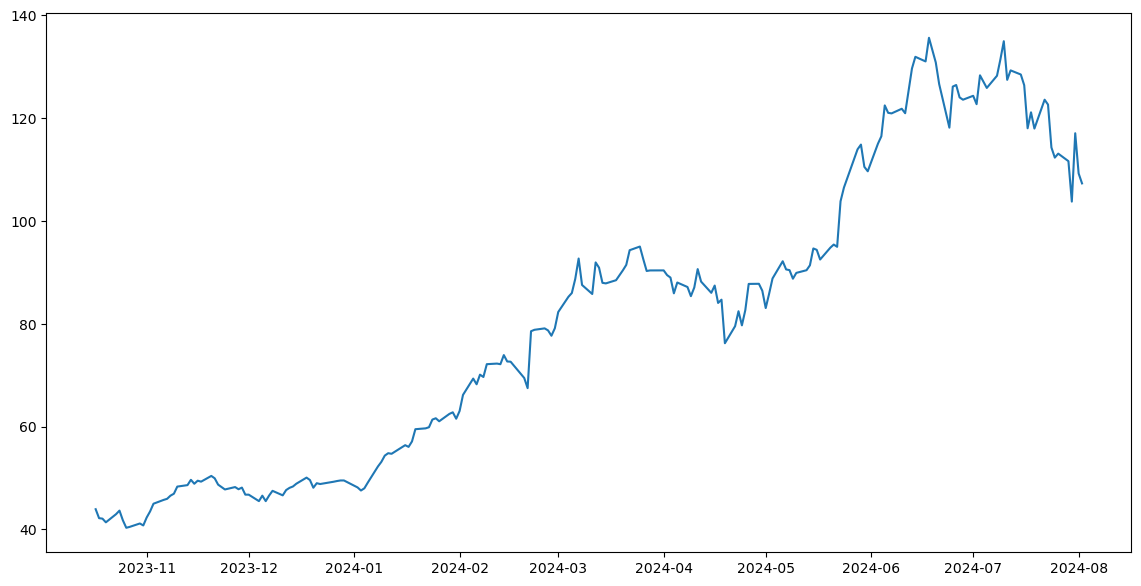

In [23]:
ticker = yf.Ticker('NVDA')
data = ticker.history("max")
data.index = data.index.date
print(data)
plt.rcParams['figure.figsize'] = [14, 7]
plt.plot(data['Close'][-200:], label='Close Price')

In [24]:
moves = market_move(data, step=20, delta=20)
print(moves)

         Start         End  Price_start   Price_end          Move  \
0   2016-05-13  2016-11-04     1.003680    1.662274     UpWhipsaw   
1   2016-11-04  2016-12-22     1.662274    2.638934            Up   
2   2016-12-22  2017-04-20     2.638934    2.497953  Consolidated   
3   2017-04-20  2017-06-08     2.497953    3.949668            Up   
4   2017-06-08  2017-12-29     3.949668    4.785952     UpWhipsaw   
5   2017-12-29  2018-01-23     4.785952    5.909105            Up   
6   2018-01-23  2018-04-25     5.909105    5.362110  Consolidated   
7   2018-04-25  2018-05-10     5.362110    6.437949            Up   
8   2018-05-10  2018-10-03     6.437949    7.104544  Consolidated   
9   2018-10-03  2018-11-19     7.104544    3.585351          Down   
10  2018-11-19  2019-08-15     3.585351    3.697903  Consolidated   
11  2019-08-15  2019-09-05     3.697903    4.472133            Up   
12  2019-09-05  2020-01-31     4.472133    5.886982     UpWhipsaw   
13  2020-01-31  2020-02-19     5.8

In [25]:
moves = market_move(data, step=30, delta=20)
print(moves)

         Start         End  Price_start   Price_end          Move  \
0   2016-05-13  2016-06-27     1.003680    1.110892  Consolidated   
1   2016-06-27  2016-08-08     1.110892    1.442392            Up   
2   2016-08-08  2016-11-04     1.442392    1.662274  Consolidated   
3   2016-11-04  2016-12-27     1.662274    2.890484            Up   
4   2016-12-27  2017-05-08     2.890484    2.535202  Consolidated   
5   2017-05-08  2017-07-20     2.535202    4.136360            Up   
6   2017-07-20  2018-04-09     4.136360    5.331175     UpWhipsaw   
7   2018-04-09  2018-05-10     5.331175    6.437949            Up   
8   2018-05-10  2018-10-01     6.437949    7.169709  Consolidated   
9   2018-10-01  2018-12-24     7.169709    3.151916          Down   
10  2018-12-24  2019-01-25     3.151916    3.972139            Up   
11  2019-01-25  2019-04-24     3.972139    4.746401  Consolidated   
12  2019-04-24  2019-06-03     4.746401    3.325305          Down   
13  2019-06-03  2019-07-12     3.3